<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/weibo_wmmBERT_testing_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

## 0-1 Install Dependences

In [27]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 0-2 Parameters

In [28]:
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [29]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1 Load Dataset

## 1-1 Download ICI election dataset

In [30]:
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx

File ‘df_sample.xlsx’ already there; not retrieving.



In [31]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['angry']=0 #neg
    ici_map_dict['anger']=0 #neg
    ici_map_dict['positive']=1 #pos
    ici_map_dict['posiitive']=1 #pos
    ici_map_dict['happy']=1 #pos
    ici_map_dict['neutral']=3 #ignore
    ici_map_dict['neural']=3 #ignore
    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['suprise']=3 #ignore
    ici_map_dict['sad']=0 #neg
    ici_map_dict['negative']=0 #neg
    ici_map_dict['fear']=0 #neg

len(ici_map_dict)

12

In [32]:
import pandas as pd

In [33]:
testing_pd = pd.read_excel('/content/df_sample.xlsx')

testing_pd = testing_pd[['text', 'sentiment']]
testing_pd = testing_pd.rename(columns={'sentiment':'label'})

In [34]:
testing_pd.label.unique()

array(['neutral', 'fear', 'anger ', 'posiitive', 'positive', 'suprise',
       'surprise', 'sad', 'anger', 'neutral, positive',
       'neutral, surprise', 'Positive', 'Anger', 'surprise, positive',
       'Neutral', 'Fear', 'Fear, surprise', 'Surprise, negative',
       'anger, fear', 'Surprise', 'Anger, fear', 'Anger, negative',
       'Anger, surprise', 'Negative', 'Angry', 'angry', 'anger, surprise',
       'anger, negative', 'positive, surprise', 'happy', 'neural'],
      dtype=object)

In [35]:
#testing_pd = pd.read_excel('/content/df_sample.xlsx')

#testing_pd = testing_pd[['text', 'sentiment']]
#testing_pd = testing_pd.rename(columns={'sentiment':'label'})

# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(200, 2)

In [36]:
testing_pd

,text,label
0,【谈北市选战三脚督柯文哲点出“2情况”：蓝绿都投黄珊珊】九合一选举年底登场，台北市长选战“三...,3
1,【黄珊珊民调反超陈时中、威胁蒋万安？ 郭正亮：关键在这群人】对于有台北市长选举民调显示，蒋万...,0
2,【台北市长选战若三脚督 阿扁最新预测：这人恐被弃保】台北市长选战，民进党参选人陈时中、国民党...,0
3,【这家民调蒋万安拉警报？ 郭正亮惊爆内幕：帮陈时中冲喜】对于《东森新闻》委托“雨晴民调公司”...,0
4,"【陈时中称蒋万安防疫主张抄袭自己 蒋万安：他防疫做得这么差 谁会想抄】<a href=""h...",1
...,...,...
195,中國國民黨台北市長參選人蔣萬安選情始終無法拉開，泛藍基本盤未歸隊是主因。前立法院長王金平上周...,3
196,【外传绿下周征召陈时中选台北市 蒋万安呛：任何个人决定都不该影响防疫】国民党台北市长参选人蒋...,3
197,【周玉蔻怎能霸占黄金时段？郭正亮爆：被“有分量”金主标下】资深媒体人周玉蔻日前攻击国民党台北...,3
198,额？？？这是蒋万安的竞选团队？？？,3


In [37]:
#we can consider to not delete the titles of reposted news articles. This will be up to the ICI project group to decide
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
# title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'


testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

<ipython-input-37-5ff519dce03c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
<ipython-input-37-5ff519dce03c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
<ipython-input-37-5ff519dce03c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [38]:
testing_pd

,text,label
0,对于有台北市长选举民调显示，蒋万安冲到39％，黄珊珊24％，陈时中18％。民众党台北市议员参...,0
1,台北市长选战，民进党参选人陈时中、国民党参选人蒋万安、民众党支持的台北市副市长黄珊珊等3人，...,0
2,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
3,,1
4,,0
...,...,...
91,国民党台北市长参选人蒋万安新书今天上市。书中讲述他与老婆石舫亘爱情长跑20年的故事，蒋万安也...,0
92,资深媒体人周玉蔻近日言论火力全开，痛批慈济是中共自己人、甚至炮打证严法师，也扬言爆料国民党台...,0
93,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
94,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0


In [39]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text', 'label']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text,label
0,对于有台北市长选举民调显示，蒋万安冲到39％，黄珊珊24％，陈时中18％。民众党台北市议员参...,0
1,台北市长选战，民进党参选人陈时中、国民党参选人蒋万安、民众党支持的台北市副市长黄珊珊等3人，...,0
2,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
3,很多人根本看不懂国际局势一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。直白一点说，...,0
4,大概是个什么样子的？光阴似箭日月如梭，70年说长不长说短不短，已然超过一个甲子了。我们都知道...,0
...,...,...
89,国民党台北市长参选人蒋万安新书今天上市。书中讲述他与老婆石舫亘爱情长跑20年的故事，蒋万安也...,0
90,资深媒体人周玉蔻近日言论火力全开，痛批慈济是中共自己人、甚至炮打证严法师，也扬言爆料国民党台...,0
91,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
92,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0


In [40]:
if number_classes == 2:
    from sklearn.utils import resample

    df_majority = testing_pd[testing_pd.label==0]
    df_minority = testing_pd[testing_pd.label==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df_majority.shape[0],    # to match majority class
                                    random_state=42) # reproducible results

    # Combine majority class with upsampled minority class
    testing_pd = pd.concat([df_majority, df_minority_upsampled])


In [41]:
num_label = len(testing_pd['label'].unique())
num_label

2

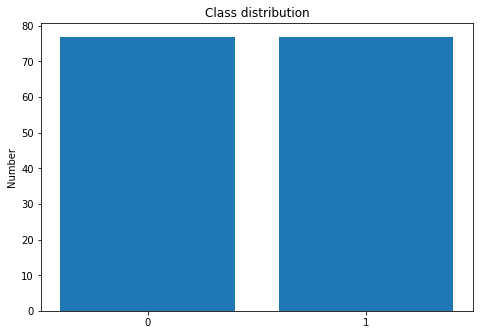

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(testing_pd['label'].unique(),
       testing_pd.groupby(['label']).count()['text'].tolist())

ax.set_xticks(testing_pd.groupby(['label']).count().index.values)

ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [43]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [44]:
from transformers import AutoTokenizer

In [45]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-bert-wwm/snapshots/ab0aa81da273504efc8540aa4d0bbaa3016a1bb5/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-bert-wwm",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

In [46]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [47]:
full_test_dataset = tokenized_datasets["test"]

# 2. Testing

## 2-1 Download ICI model

In [48]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--owen198--weibo-wmmbert-2/snapshots/1c8b069ca4f42474887b1be5ddb45d0b190b785d/config.json
Model config BertConfig {
  "_name_or_path": "owen198/weibo-wmmbert-2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "f

In [49]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## 2-2 Get Accuracy

In [50]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [51]:
import numpy as np

# trainer.evaluate()

In [52]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 154
  Batch size = 8


In [53]:
pred.metrics

{'test_loss': 0.6584441661834717,
 'test_accuracy': 0.8441558441558441,
 'test_runtime': 292.2258,
 'test_samples_per_second': 0.527,
 'test_steps_per_second': 0.068}

In [54]:
pred

PredictionOutput(predictions=array([[-1.8040092 ,  1.7588141 ],
       [-1.9969726 ,  2.064629  ],
       [ 2.0315375 , -2.6380615 ],
       [ 2.1272569 , -2.7456036 ],
       [ 1.0068587 , -0.31965894],
       [ 1.9081945 , -2.5041854 ],
       [-2.2814538 ,  2.4072642 ],
       [ 2.1923296 , -2.8309183 ],
       [ 2.352627  , -3.3197086 ],
       [ 0.44593245,  0.07042068],
       [-2.5946174 ,  2.6294167 ],
       [ 2.4960234 , -3.7117014 ],
       [-1.9568505 ,  2.0052001 ],
       [ 2.1429963 , -2.7647827 ],
       [ 2.2662385 , -2.9734206 ],
       [ 1.4590896 , -1.6853566 ],
       [ 1.9701102 , -2.5720158 ],
       [ 1.6956582 , -2.2208443 ],
       [ 0.985988  , -0.19088715],
       [ 1.7562492 , -2.3144002 ],
       [ 2.3063278 , -3.1176062 ],
       [ 2.4894824 , -3.6979547 ],
       [ 2.3038683 , -3.1064792 ],
       [-0.67889464,  0.8905391 ],
       [-2.0075397 ,  2.0798976 ],
       [ 1.8291421 , -2.4113708 ],
       [ 1.044617  , -0.38654837],
       [ 2.313437  , -3.15

In [55]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [56]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [57]:
testing_pd

,text,label,pred
0,对于有台北市长选举民调显示，蒋万安冲到39％，黄珊珊24％，陈时中18％。民众党台北市议员参...,0,1
1,台北市长选战，民进党参选人陈时中、国民党参选人蒋万安、民众党支持的台北市副市长黄珊珊等3人，...,0,1
2,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0,0
3,很多人根本看不懂国际局势一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。直白一点说，...,0,0
4,大概是个什么样子的？光阴似箭日月如梭，70年说长不长说短不短，已然超过一个甲子了。我们都知道...,0,0
...,...,...,...
30,国民党台北市长参选人蒋万安选情吃紧，2014年曾参选过台北市长的党副主席连胜文今天表示，蒋万...,1,1
17,年底选举脚步逼近，新竹传出要蓝白合“用高虹安换蒋万安”。国民党台北市长参选人蒋万安表示，这个...,1,1
17,年底选举脚步逼近，新竹传出要蓝白合“用高虹安换蒋万安”。国民党台北市长参选人蒋万安表示，这个...,1,1
6,九合一选举，台北市长选战成外界关注焦点！据最新民调显示，国民党参选人蒋万安以36.9%支持居...,1,1
